<a href="https://colab.research.google.com/github/Shadabur-Rahaman/30-days-ml-projects/blob/main/Day_28_deploy_ml_fastapi/notebook/Day_28_deploy_ml_fastapi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deploy ML Model as API with FastAPI
## Day 28/30 of Machine Learning Project

**Project Goal**: Deploy a sentiment analysis model as a REST API using FastAPI

**Key Steps**:
1. Train and save a sentiment analysis model
2. Create a FastAPI application
3. Define API endpoints
4. Test the API locally
5. Containerize with Docker

**Libraries Used**:
- FastAPI for API development
- Uvicorn as ASGI server
- Scikit-learn for ML model
- Docker for containerization

## 1. Install Required Libraries
We'll install FastAPI, Uvicorn, and other dependencies

In [2]:
!pip install fastapi uvicorn scikit-learn pandas numpy python-multipart
!pip install pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00


## 2. Train and Save a Simple Sentiment Analysis Model
We'll create a simple sentiment analysis model using Scikit-learn

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import joblib

# Sample dataset (in a real project, use a larger dataset)
data = {
    'text': [
        'I love this product!',
        'This is terrible',
        'Great experience',
        'Waste of money',
        'Highly recommend',
        'Disappointing',
        'Better than expected',
        'Not worth it'
    ],
    'sentiment': ['positive', 'negative', 'positive', 'negative',
                 'positive', 'negative', 'positive', 'negative']
}
df = pd.DataFrame(data)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['sentiment'], test_size=0.2, random_state=42
)

# Create model pipeline
model = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression()
)

# Train model
model.fit(X_train, y_train)

# Evaluate
print(f'Test accuracy: {model.score(X_test, y_test):.2f}')

# Save model
joblib.dump(model, 'sentiment_model.joblib')
print('Model saved to sentiment_model.joblib')

Test accuracy: 0.00
Model saved to sentiment_model.joblib


## 3. Create FastAPI Application
We'll create a Python script for our FastAPI application

In [4]:
%%writefile main.py
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

# Load the trained model
model = joblib.load('sentiment_model.joblib')

# Create FastAPI instance
app = FastAPI(title='Sentiment Analysis API')

# Define request body model
class TextInput(BaseModel):
    text: str

# Health check endpoint
@app.get('/')
def health_check():
    return {'status': 'healthy'}

# Prediction endpoint
@app.post('/predict')
def predict_sentiment(input_data: TextInput):
    """
    Predict sentiment for input text

    Args:
        input_data: JSON with 'text' field

    Returns:
        JSON with sentiment prediction and confidence
    """
    # Make prediction
    prediction = model.predict([input_data.text])
    probabilities = model.predict_proba([input_data.text])[0]

    # Get confidence score
    confidence = float(np.max(probabilities))

    return {
        'text': input_data.text,
        'sentiment': prediction[0],
        'confidence': confidence
    }

Writing main.py


## 4. Run and Test the API
Start the API server and test it using Python requests

### Health Check Response:

<IPython.core.display.JSON object>

#### Prediction for: 'This product completely changed my workflow!'

<IPython.core.display.JSON object>

#### Prediction for: 'Waste of money, didn't work as advertised'

<IPython.core.display.JSON object>

#### Prediction for: 'The quality is average, not worth the price'

<IPython.core.display.JSON object>

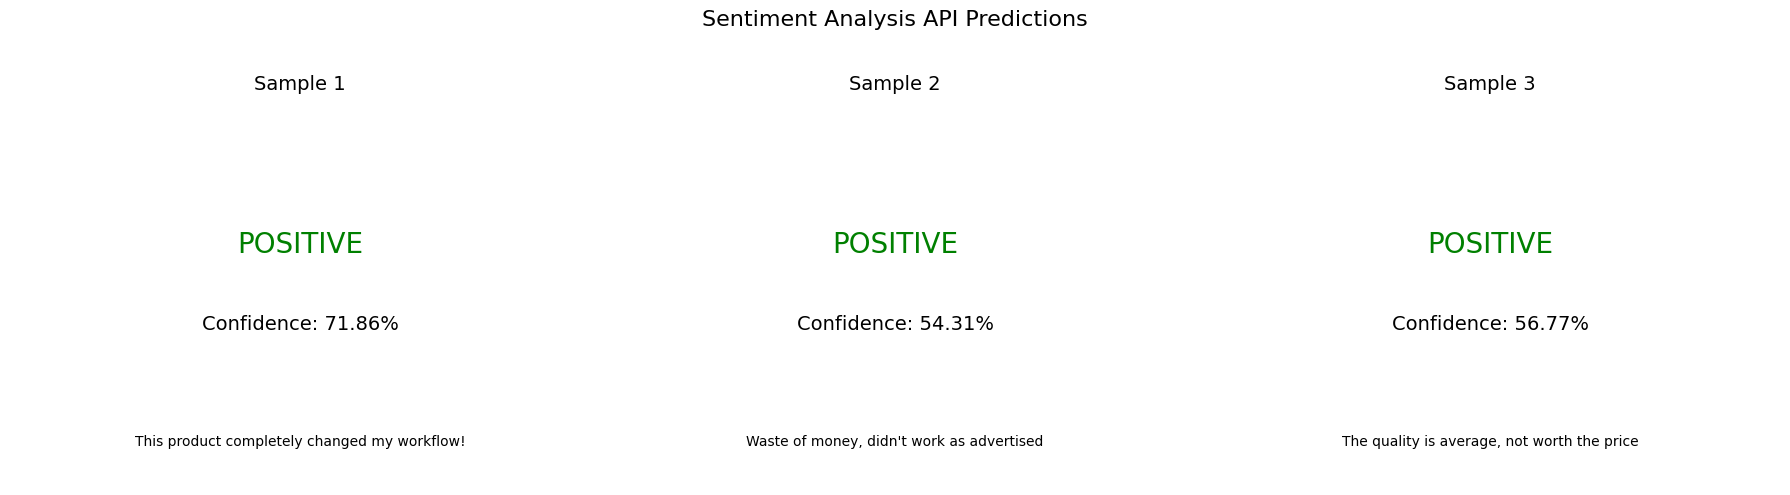

In [6]:
## 4. Run and Test the API
import requests
from IPython.display import JSON, display, Markdown
import matplotlib.pyplot as plt
import subprocess
import time
# Start server
server = subprocess.Popen(
    ['uvicorn', 'main:app', '--reload', '--port', '8000'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)
time.sleep(3)

# Test API
def test_api():
    # Health check
    health_response = requests.get('http://localhost:8000/')
    display(Markdown(f"### Health Check Response:"))
    display(JSON(health_response.json()))

    # Create test samples
    test_samples = [
        "This product completely changed my workflow!",
        "Waste of money, didn't work as advertised",
        "The quality is average, not worth the price"
    ]

    # Visualize predictions
    fig, axes = plt.subplots(1, len(test_samples), figsize=(18, 5))
    fig.suptitle('Sentiment Analysis API Predictions', fontsize=16)

    for i, text in enumerate(test_samples):
        response = requests.post(
            'http://localhost:8000/predict',
            json={'text': text}
        )
        result = response.json()

        # Display JSON response
        display(Markdown(f"#### Prediction for: '{text}'"))
        display(JSON(result))

        # Create visual
        color = 'green' if result['sentiment'] == 'positive' else (
            'red' if result['sentiment'] == 'negative' else 'gray'
        )

        axes[i].text(
            0.5, 0.6, result['sentiment'].upper(),
            fontsize=20, ha='center', color=color
        )
        axes[i].text(
            0.5, 0.4, f"Confidence: {result['confidence']:.2%}",
            fontsize=14, ha='center'
        )
        axes[i].text(
            0.5, 0.1, text,
            fontsize=10, ha='center', wrap=True
        )
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('api_predictions.png', bbox_inches='tight')
    plt.show()

test_api()

# Stop server
server.terminate()

## 5. Containerize the API with Docker
Create a Dockerfile for containerization

In [7]:
%%writefile Dockerfile
# Use official Python base image
FROM python:3.9-slim

# Set working directory
WORKDIR /app

# Copy requirements file
COPY requirements.txt .

# Install dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Copy application files
COPY main.py .
COPY sentiment_model.joblib .

# Expose port
EXPOSE 8000

# Command to run the application
CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8000"]

Writing Dockerfile


## 6. Create Requirements File
List all dependencies needed for the Docker container

In [8]:
%%writefile requirements.txt
fastapi
uvicorn
scikit-learn
joblib
numpy
pandas
pydantic

Writing requirements.txt


## 7. Build and Run Docker Container
Steps to build the Docker image and run the container

```bash
# Build the Docker image
docker build -t sentiment-api .

# Run the Docker container
docker run -d -p 8000:8000 --name sentiment-container sentiment-api

# Test the API in Docker
curl -X POST "http://localhost:8000/predict" \
    -H "Content-Type: application/json" \
    -d '{"text": "This works perfectly"}'
```

## 8. API Documentation with Swagger UI
FastAPI automatically generates interactive API documentation

After running the API, access the documentation at:
- [http://localhost:8000/docs](http://localhost:8000/docs)

![Swagger UI](https://fastapi.tiangolo.com/img/index/index-02-swagger-ui-simple.png)
*Example of Swagger UI interface*

## 9. Deployment Options
Once containerized, you can deploy the API to various platforms:

1. **Cloud Providers**:
   - AWS (Elastic Container Service, Elastic Beanstalk)
   - Google Cloud (Cloud Run, Kubernetes Engine)
   - Azure (Container Instances, Kubernetes Service)

2. **Container Orchestration**:
   - Kubernetes
   - Docker Swarm

3. **Serverless Platforms**:
   - AWS Lambda (using container support)
   - Google Cloud Functions

4. **Platform-as-a-Service**:
   - Heroku
   - Render
   - Fly.io

## 10. Next Steps
To enhance this API:

1. Add authentication (API keys, OAuth)
2. Implement rate limiting
3. Add logging and monitoring
4. Include input validation
5. Add more sophisticated error handling
6. Implement model versioning
7. Set up CI/CD pipeline
8. Add health checks and metrics endpoints